In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import keras.metrics as km
 
 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

import keras
import numpy as np
from time import time
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from matplotlib import pyplot

In [ ]:
data_dir = '/content/drive/MyDrive/CONVLSTM123/'
img_height , img_width =320,320 
seq_len = 22
batch_size = 8
classes = ["Col-0", "Cvi", "Ler-1", "Sf-2"]

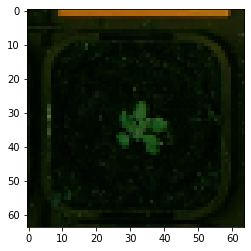

In [ ]:
img = cv2.imread("/content/drive/MyDrive/CONVLSTM123/Col-0/BVZ0072-GC35L-RGB01~fullres-cor-T01-D4-35519-Col-0/BVZ0072-GC35L-RGB01~fullres-cor-T01-D4-35519_2016_10_01_12_00_00_00.jpg")
img = cv2.resize(img, (img_height, img_width))
pyplot.imshow(img)

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
     
    for c in classes_list:
        print(c)
        dir_list = os.listdir(os.path.join(input_dir, c))
        for d in dir_list:
           frames = frames_extraction(os.path.join(os.path.join(input_dir, c), d))
           if len(frames) == seq_len:
             X.append(frames)
             y = [0]*len(classes)
             y[classes.index(c)] = 1
             Y.append(y)
     
    X = np.asarray(X).astype('uint8')
    Y = np.asarray(Y).astype('uint8')
    return X, Y

In [ ]:
X, Y = create_data(data_dir)

Col-0
Cvi
Ler-1
Sf-2
.ipynb_checkpoints


In [ ]:
X.shape, Y.shape

((520, 22, 64, 64, 3), (520, 4))

In [ ]:
np.save("/content/drive/MyDrive/Accession_class/CONVLSTM/Accession_img",X)
np.save("/content/drive/MyDrive/Accession_class/CONVLSTM/Class",Y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.10, shuffle=True, random_state=0)

In [ ]:
X_test.shape

(130, 22, 320, 320, 3)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, shuffle=True, random_state=0)

In [ ]:
X_train.shape

(390, 22, 320, 320, 3)

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(10, (3, 3), activation = 'relu',padding="valid"),input_shape = (22,320,320,3)))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(filters=20, kernel_size=(3,3), padding="valid", activation="relu")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(filters=40, kernel_size=(3,3), padding="valid", activation="relu")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Conv2D(filters=80, kernel_size=(3,3), padding="valid", activation="relu")))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(ConvLSTM2D(filters = 40, kernel_size = (3, 3), return_sequences = True))
model.add(Dropout(0.2))
model.add(ConvLSTM2D(filters = 10, kernel_size = (3, 3), return_sequences = False))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(4, activation = "softmax"))


In [ ]:
model.summary()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
earlystop=EarlyStopping(patience=9)
callbacks=[earlystop]
history = model.fit(x = X_train, y = y_train, epochs=80, batch_size =4)


In [ ]:
model.evaluate(X_test,y_test,4)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']

loss = history.history['loss']


epochs_range = range(80)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Accuracy and Loss')


In [ ]:
from sklearn.metrics import classification_report
y_pred= model.predict(X_test,4)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))